In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

df = pd.read_csv('../party_speeches_classification_cleaned.csv')

/tmp/ipykernel_23987/3512999055.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('party_speeches_classification_cleaned.csv')


In [2]:
# Drop rows with no party
df = df.dropna(subset=['party'])

# Step 1: Build a topic distribution per speech
def build_topic_dist(row):
    dist = {}
    for i in range(1, 4):
        topic = row[f'top_{i}_topic']
        prob = row[f'top_{i}_prob']
        if isinstance(topic, str) and ' - ' in topic:
            topic_id = topic.split(' - ')[0].strip()
            dist[topic_id] = dist.get(topic_id, 0) + prob
    return dist

df['topic_dist'] = df.apply(build_topic_dist, axis=1)

# Step 2: Aggregate distributions per party
party_topic_counts = defaultdict(lambda: defaultdict(float))

for _, row in df.iterrows():
    party = row['party']
    for topic, prob in row['topic_dist'].items():
        party_topic_counts[party][topic] += prob

# Get all unique topics
all_topics = sorted({topic for counts in party_topic_counts.values() for topic in counts})

# Step 3: Normalize to probability distributions
party_dists = {}
for party, topic_count in party_topic_counts.items():
    vec = np.array([topic_count.get(topic, 0) for topic in all_topics])
    vec = vec / vec.sum()  # normalize
    party_dists[party] = vec

# Mapping of the ideological scores using the manifestoberta topics

In [3]:
ideology_dimensions = {
    'Economic_Left_Right': {
        'left': ['412', '413', '415', '504', '409', '503'],
        'right': ['401', '402', '404', '505', '414'],
    },
    'Cultural_Progressive_Conservative': {
        'left': ['604', '607', '705', '706', '503'],
        'right': ['603', '601', '605', '606'],
    },
    'Globalist_Nationalist': {
        'left': ['107', '108', '101', '106'],
        'right': ['109', '110', '102', '104'],
    },
    'Libertarian_Authoritarian': {
        'left': ['201', '202', '604'],
        'right': ['603', '601', '605'],
    }
}


/tmp/ipykernel_23987/2690135828.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(parties))


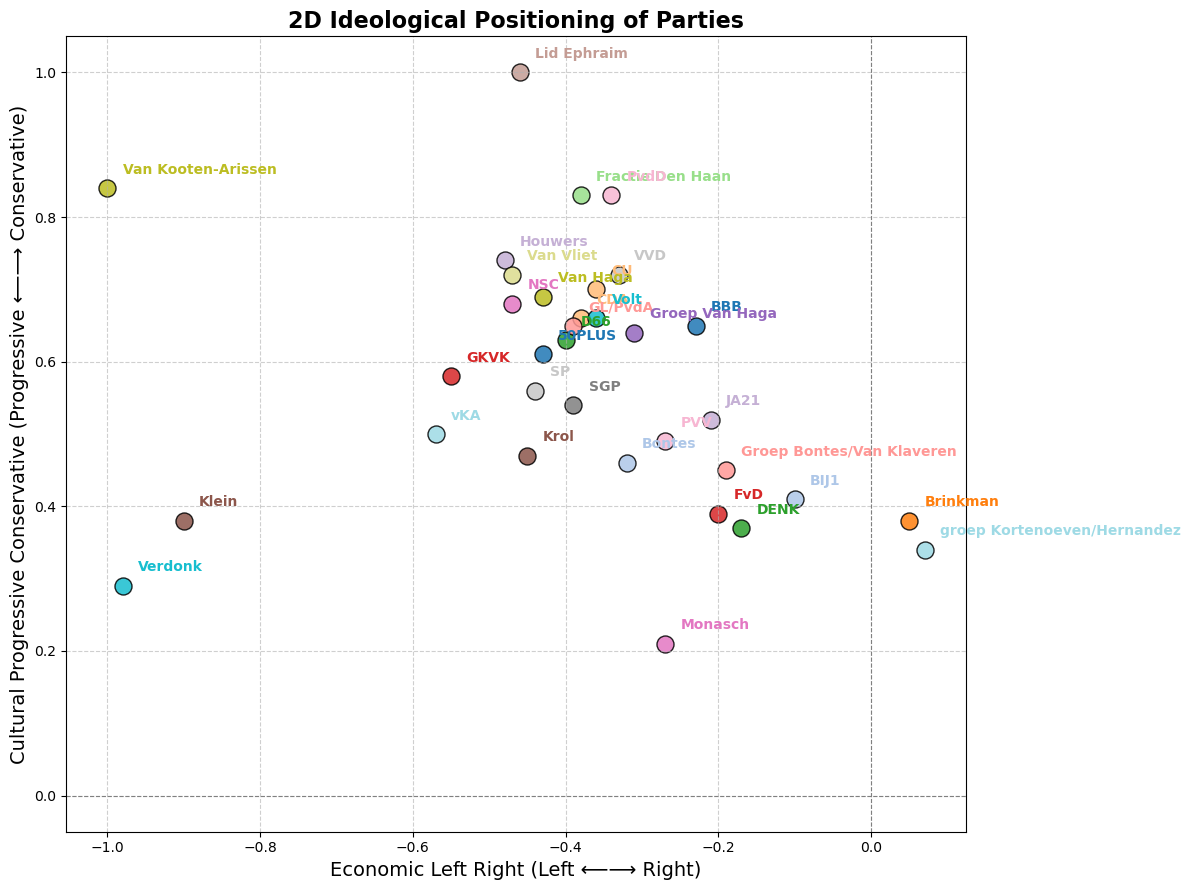

In [4]:
# Accumulate sums and counts to later average
party_scores = defaultdict(lambda: defaultdict(float))
party_counts = defaultdict(int)

for _, row in df.iterrows():
    party = row.get('party')
    topic_dist = row.get('topic_dist')
    
    if pd.isna(party) or not isinstance(topic_dist, dict):
        continue
    
    party_counts[party] += 1
    
    for dim, sides in ideology_dimensions.items():
        left_score = sum(topic_dist.get(str(t), 0) for t in sides['left'])
        right_score = sum(topic_dist.get(str(t), 0) for t in sides['right'])
        party_scores[party][dim] += (right_score - left_score)

# Average scores per party
for party in party_scores:
    count = party_counts[party] if party_counts[party] > 0 else 1
    for dim in ideology_dimensions:
        party_scores[party][dim] /= count

# Normalize scores to [-1, 1] per dimension
normalized_scores = defaultdict(dict)
for dim in ideology_dimensions:
    scores = [abs(party_scores[party][dim]) for party in party_scores]
    max_abs = max(scores) if scores else 1
    for party in party_scores:
        normalized_scores[party][dim] = round(party_scores[party][dim] / max_abs, 2) if max_abs > 0 else 0

# Create DataFrame
ideology_df = pd.DataFrame(normalized_scores).T.sort_index()

# Plotting
x_dim = 'Economic_Left_Right'
y_dim = 'Cultural_Progressive_Conservative'

plt.figure(figsize=(12, 9))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

parties = ideology_df.index.tolist()
colors = plt.cm.get_cmap('tab20', len(parties))
party_color_map = {party: colors(i) for i, party in enumerate(parties)}

for party, row in ideology_df.iterrows():
    x = row.get(x_dim, 0)
    y = row.get(y_dim, 0)
    plt.scatter(x, y, s=150, color=party_color_map[party], edgecolors='black', alpha=0.85)
    plt.text(x + 0.02, y + 0.02, party, fontsize=10, fontweight='bold', color=party_color_map[party])

plt.xlabel(f"{x_dim.replace('_', ' ')} (Left ⟵⟶ Right)", fontsize=14)
plt.ylabel(f"{y_dim.replace('_', ' ')} (Progressive ⟵⟶ Conservative)", fontsize=14)
plt.title("2D Ideological Positioning of Parties", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_23987/1847906662.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(parties))


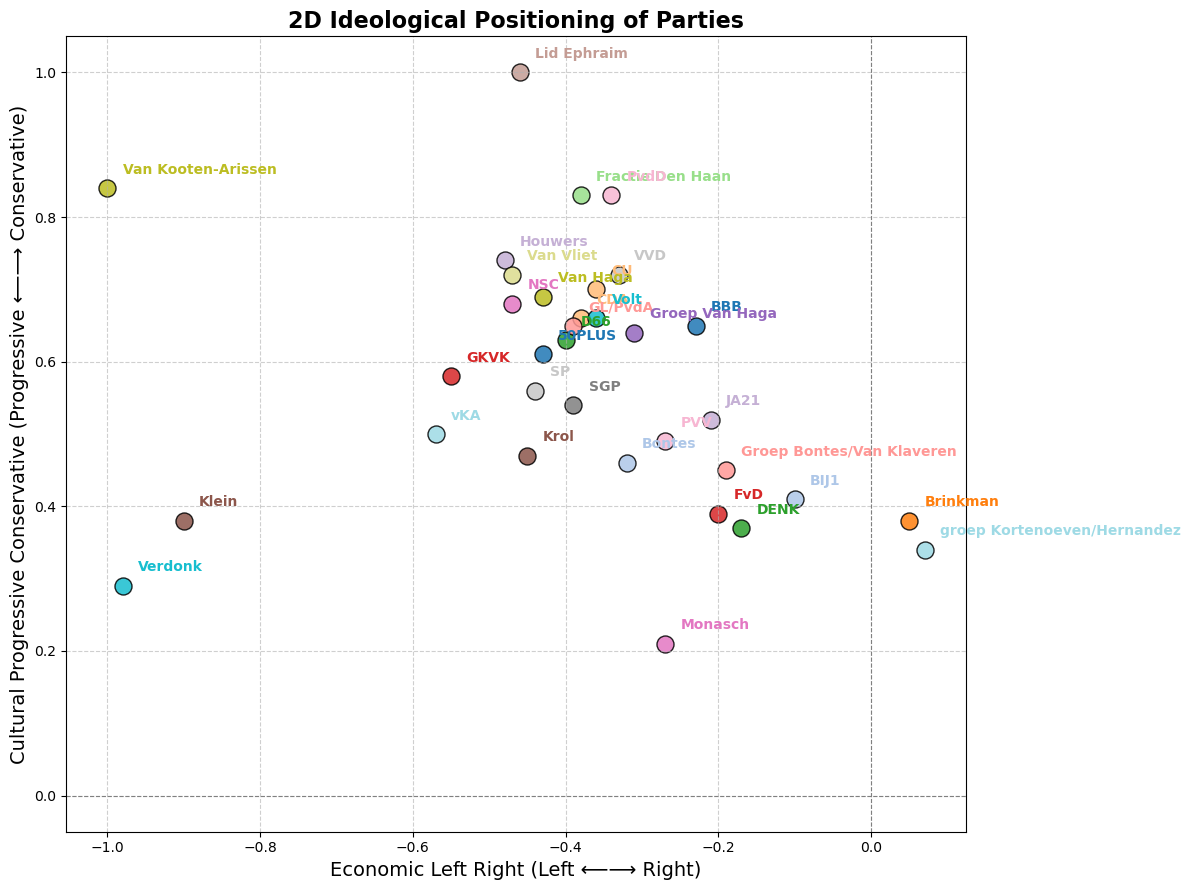

In [5]:
# ideology_dimensions is assumed defined as before

party_scores = defaultdict(lambda: defaultdict(float))
party_counts = defaultdict(int)

for _, row in df.iterrows():
    party = row.get('party')
    topic_dist = row.get('topic_dist')
    
    if pd.isna(party) or not isinstance(topic_dist, dict):
        continue
    
    party_counts[party] += 1
    
    for dim, sides in ideology_dimensions.items():
        # Convert topic IDs to strings to match keys
        left_score = sum(topic_dist.get(str(t), 0) for t in sides['left'])
        right_score = sum(topic_dist.get(str(t), 0) for t in sides['right'])
        party_scores[party][dim] += (right_score - left_score)

# Average per party
for party in party_scores:
    count = party_counts[party] if party_counts[party] > 0 else 1
    for dim in ideology_dimensions:
        party_scores[party][dim] /= count

# Normalize to [-1, 1]
normalized_scores = defaultdict(dict)
for dim in ideology_dimensions:
    scores = [abs(party_scores[party][dim]) for party in party_scores]
    max_abs = max(scores) if scores else 1
    for party in party_scores:
        normalized_scores[party][dim] = round(party_scores[party][dim] / max_abs, 2) if max_abs > 0 else 0

ideology_df = pd.DataFrame(normalized_scores).T.sort_index()

# === Plotting ===
x_dim = 'Economic_Left_Right'
y_dim = 'Cultural_Progressive_Conservative'

plt.figure(figsize=(12, 9))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

parties = ideology_df.index.tolist()
colors = plt.cm.get_cmap('tab20', len(parties))
party_color_map = {party: colors(i) for i, party in enumerate(parties)}

for party, row in ideology_df.iterrows():
    x = row.get(x_dim, 0)
    y = row.get(y_dim, 0)
    plt.scatter(x, y, s=150, color=party_color_map[party], edgecolors='black', alpha=0.85)
    plt.text(x + 0.02, y + 0.02, party, fontsize=10, fontweight='bold', color=party_color_map[party])

plt.xlabel(f"{x_dim.replace('_', ' ')} (Left ⟵⟶ Right)", fontsize=14)
plt.ylabel(f"{y_dim.replace('_', ' ')} (Progressive ⟵⟶ Conservative)", fontsize=14)
plt.title("2D Ideological Positioning of Parties", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:

ideology_df = pd.DataFrame(normalized_scores).T.sort_index()

# Save to CSV
ideology_df.to_csv('party_ideology_scores.csv')

print("Ideology scores saved to party_ideology_scores.csv")


Ideology scores saved to party_ideology_scores.csv
